In [1]:
#import required libraries
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import vtk

---

### Import well location and lithology

From the publicacion: https://pubs.usgs.gov/sir/2019/5138/sir20195138_v1.1.pdf The selected units would be:

1. Coarse-grained fluvial and alluvial deposits
2. Pliocene-Pleistocene and Miocene basalts
3. Fine-grained lacustrine deposits
4. Rhyolitic and granitic bedrock

In [2]:
wellLoc = pd.read_csv('../inputData/TV-HFM_Wells_1Location_Wgs11N.csv',index_col=0)
wellLoc.head()

Easting    Northing  Altitude_ft     EastingUTM  \
Bore                                                                
A. Isaac       2333140.95  1372225.65       3204.0  575546.628834   
A. Woodbridge  2321747.00  1360096.95       2967.2  564600.366582   
A.D. Watkins   2315440.16  1342141.86       3168.3  558944.843404   
A.L. Clark; 1  2276526.30  1364860.74       2279.1  519259.006159   
A.L. Clark; 2  2342620.87  1362980.46       3848.6  585351.150270   

                NorthingUTM  Elevation_m  
Bore                                      
A. Isaac       4.820355e+06    976.57920  
A. Woodbridge  4.807827e+06    904.40256  
A.D. Watkins   4.789664e+06    965.69784  
A.L. Clark; 1  4.810959e+06    694.66968  
A.L. Clark; 2  4.811460e+06   1173.05328

In [3]:
wellLito = pd.read_csv('../inputData/TV-HFM_Wells_2Lithology_m_rcl_clip.csv',index_col=0)
wellLito.head()

Bore  Depth_top_L  Depth_bot_L PrimaryLith  topLitoElev_m  \
1309  H. Raff          0.0          1.0        Soil      770.44296   
1310  H. Raff          1.0          6.0        Clay      770.13816   
1311  H. Raff          6.0         12.0      Gravel      768.61416   
1312  H. Raff         12.0         18.0        Clay      766.78536   
1313  H. Raff         18.0         48.0      Gravel      764.95656   

      botLitoElev_m  litoCode  hydrogeoCode  
1309      770.13816         0             1  
1310      768.61416         7             3  
1311      766.78536         6             1  
1312      764.95656         7             3  
1313      755.81256         6             1

---

### Point cloud of lithologies

In [4]:
litoPoints = []

for index, values in wellLito.iterrows():
    wellX, wellY, wellZ = wellLoc.loc[values.Bore][["EastingUTM","NorthingUTM","Elevation_m"]]
    wellXY = [wellX, wellY]
    litoPoints.append(wellXY + [values.topLitoElev_m,values.hydrogeoCode])
    litoPoints.append(wellXY + [values.botLitoElev_m,values.hydrogeoCode])
    
    litoLength = values.topLitoElev_m - values.botLitoElev_m
    if litoLength < 1:
        midPoint = wellXY + [values.topLitoElev_m - litoLength/2,values.hydrogeoCode]
    else:
        npoints = int(litoLength)
        for point in range(1,npoints+1):
            disPoint = wellXY + [values.topLitoElev_m - litoLength*point/(npoints+1),values.hydrogeoCode]
            litoPoints.append(disPoint)
litoNp=np.array(litoPoints)
np.save('../outputData/litoNp',litoNp)
litoNp[:5]

array([[5.48261389e+05, 4.83802316e+06, 7.70442960e+02, 1.00000000e+00],
       [5.48261389e+05, 4.83802316e+06, 7.70138160e+02, 1.00000000e+00],
       [5.48261389e+05, 4.83802316e+06, 7.70138160e+02, 3.00000000e+00],
       [5.48261389e+05, 4.83802316e+06, 7.68614160e+02, 3.00000000e+00],
       [5.48261389e+05, 4.83802316e+06, 7.69376160e+02, 3.00000000e+00]])

--- 

### Coordinate transformation and Neural Network Classifier setup

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [6]:
litoX, litoY, litoZ = litoNp[:,0], litoNp[:,1], litoNp[:,2]
litoMean = litoNp[:,:3].mean(axis=0)
litoTrans = litoNp[:,:3]-litoMean
litoTrans[:5]

#setting up scaler
scaler = preprocessing.StandardScaler().fit(litoTrans)
litoScale = scaler.transform(litoTrans)

#check scaler
print(litoScale.mean(axis=0))
print(litoScale.std(axis=0))

[ 2.85924590e-14 -1.10313442e-15  3.89483608e-20]
[1. 1. 1.]


In [7]:
#run classifier
X = litoScale
Y = litoNp[:,3]
clf = MLPClassifier(activation='tanh',solver='lbfgs',hidden_layer_sizes=(15,15,15), max_iter=2000)
clf.fit(X,Y)

C:\Users\Gida\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(15, 15, 15), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=2000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

---
### Determination of confusion matrix

In [8]:
numberSamples = litoNp.shape[0]
expected=litoNp[:,3]
predicted = []
for i in range(numberSamples):
    predicted.append(clf.predict([litoScale[i]]))
results = confusion_matrix(expected,predicted)
print(results)

[[1370  128  377    0]
 [  67 2176   10    0]
 [ 274   33 1114    0]
 [   1    0    0  151]]


---
### Area of study and output grid refinement

In [9]:
xMin = 540000
xMax = 560000
yMin = 4820000
yMax = 4840000
zMax = int(wellLito.topLitoElev_m.max())
zMin = zMax - 300

In [10]:
cellH = 200
cellV = 20

---
### Determination of the lithology matrix

In [11]:
vertexCols = np.arange(xMin,xMax+1,cellH)
vertexRows = np.arange(yMax,yMin-1,-cellH)
vertexLays = np.arange(zMax,zMin-1,-cellV)
cellCols = (vertexCols[1:]+vertexCols[:-1])/2
cellRows = (vertexRows[1:]+vertexRows[:-1])/2 
cellLays = (vertexLays[1:]+vertexLays[:-1])/2
nCols = cellCols.shape[0]
nRows = cellCols.shape[0]
nLays = cellLays.shape[0]

In [12]:
i=0
litoMatrix=np.zeros([nLays,nRows,nCols])
for lay in range(nLays):
    for row in range(nRows):
        for col in range(nCols):
            cellXYZ = [cellCols[col],cellRows[row],cellLays[lay]]
            cellTrans = cellXYZ - litoMean
            cellNorm = scaler.transform([cellTrans])
            
            litoMatrix[lay,row,col] = clf.predict(cellNorm)
            
            if i%30000==0:
                print("Processing %s cells"%i)
                print(cellTrans)
                print(cellNorm)
                print(litoMatrix[lay,row,col])
            i+=1
            

Processing 0 cells
[-8553.96427073  8028.26104284   356.7050941 ]
[[-1.41791371  2.42904321  1.11476509]]
3.0
Processing 30000 cells
[-8553.96427073  8028.26104284   296.7050941 ]
[[-1.41791371  2.42904321  0.92725472]]
3.0
Processing 60000 cells
[-8553.96427073  8028.26104284   236.7050941 ]
[[-1.41791371  2.42904321  0.73974434]]
3.0
Processing 90000 cells
[-8553.96427073  8028.26104284   176.7050941 ]
[[-1.41791371  2.42904321  0.55223397]]
2.0
Processing 120000 cells
[-8553.96427073  8028.26104284   116.7050941 ]
[[-1.41791371  2.42904321  0.3647236 ]]
2.0


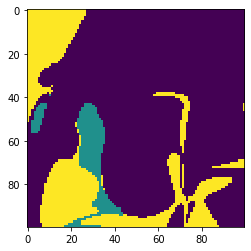

In [13]:
plt.imshow(litoMatrix[0])

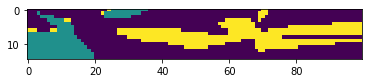

In [14]:
plt.imshow(litoMatrix[:,60])

In [15]:
np.save('../outputData/litoMatrix',litoMatrix)

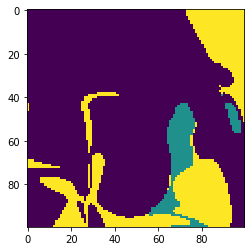

In [16]:
#matrix modification for Vtk representation
litoMatrixMod = litoMatrix[:,:,::-1]
np.save('../outputData/litoMatrixMod',litoMatrixMod)
plt.imshow(litoMatrixMod[0])

---
### Generation of regular grid VTK

In [17]:
import pyvista
import vtk

In [18]:
# Create empty grid
grid = pyvista.RectilinearGrid()

In [19]:
# Initialize from a vtk.vtkRectilinearGrid object
vtkgrid = vtk.vtkRectilinearGrid()
grid = pyvista.RectilinearGrid(vtkgrid)
grid = pyvista.RectilinearGrid(vertexCols,vertexRows,vertexLays)

In [20]:
litoFlat = list(litoMatrixMod.flatten(order="K"))[::-1]
grid.cell_arrays["hydrogeoCode"] = np.array(litoFlat)
grid.save('../outputData/hydrogeologicalUnit.vtk')